In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
from masks import subtractor

#
# Open the video

In [3]:
# path with the video
VIDEO = './data/videos/Rua.mp4'

# get the video
cap = cv2.VideoCapture(VIDEO)

# give an id for each frame
frames_ids = cap.get(cv2.CAP_PROP_FRAME_COUNT) * np.random.uniform(size=75)

#
# Visualizing frames

The method ```cap.read()``` returns a tuple with a **boolean** value and an **np.array**. The **np.array** is an image matrix, that is a frame of the video. Everytime that the method ```cap.read()``` is called, it returns the next frame of the video, just like the method ```___next___```. 

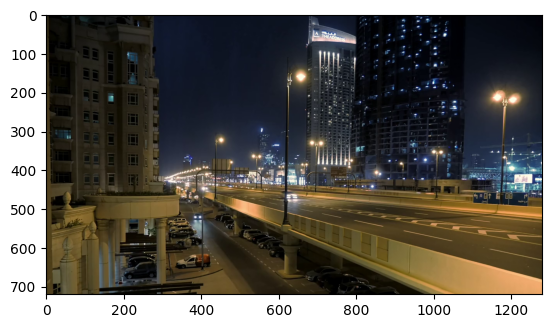

In [4]:
# takes the frames
has_frame, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# plot the frame
plt.imshow(frame)
plt.show()

#
# Median frame
The mainly idea a **median frame** is to represent the general information of a set of frames. On this case, the median frame will get the pixels more present in all video. It will be used to recognize all the new frames that is not in medianframe and consider it as an external object.

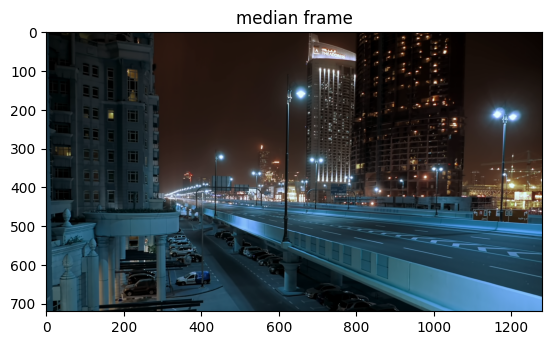

In [5]:
frames = []

# loop that creates the median frame
for id in frames_ids:
    # defines the initial position of video to the id frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, id)

    # get the next frame
    has_frame, frame = cap.read()

    # save the frame
    frames.append(frame)

# creates the median frame
median_frame = np.median(frames, axis=0).astype(np.uint8)


# plot the median frame
plt.imshow(median_frame)
plt.title('median frame')
plt.show()

#
# Turn the video into gray scale

In [6]:
# defines that de video will start from the frame 0
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# turn the median frame into gray scale
gray_median_frame = cv2.cvtColor(median_frame, cv2.COLOR_BGR2GRAY)

# saves the gray median frame
cv2.imwrite('data/images/gray_median_frame.jpg', gray_median_frame)

True

#
# Difference frames

The method ```cv2.absdiff()``` is used to calculate de absolute difference with two frames. In this case, it removes the background and let only the frames that is not part of median frame, in other words the cars.

In [7]:
delay = 10

# iter through each frame
cap = cv2.VideoCapture(VIDEO)
while True:
    # slow down the video
    fps = float(1 / delay)
    time.sleep(fps)

    # get the frame
    has_frame, frame = cap.read()

    # break if has no frames
    if not has_frame:
        break

    # turn into gray
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # take the difference frame
    dif_frame = cv2.absdiff(gray_frame, gray_median_frame)

    # show the difference frames
    cv2.imshow('frame', dif_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# exit the video
cv2.destroyAllWindows()

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/matheus/.local/lib/python3.11/site-packages/cv2/qt/plugins"


#
# Apply filter in the difference frame

Here we apply manualy a threshold filter (binarization) to visualize how it works in the video.

In [8]:
delay = 500

# iter through the frames
cap = cv2.VideoCapture(VIDEO)
while True:
    # slow down the video
    fps = float(1 / delay)
    time.sleep(fps)

    # get the frame
    has_frame, frame = cap.read()

    # break if has no frames
    if not has_frame:
        break

    # turn into gray
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # take the difference frame
    dif_frame = cv2.absdiff(gray_frame, gray_median_frame)

    # apply a binary filter
    _, dif_frame = cv2.threshold(dif_frame, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # show the results
    cv2.imshow('frame', dif_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# exit the video
cv2.destroyAllWindows()
cap.release()

#
# Applying a machine learning algorithm as filter

We choose a machine learning algorithm to remove the noise from the mask:
* **KNN**: Uses the pixel's distances to define what is object and what is the background (3.42).
* **GMG**: Uses Bayes Theorem to learn and identify possible objects (5.42).
* **CNT**: Uses informations about the last frames to predict what is the meaning of the pixels of the next frame (2.26).
* **MOG**: Each pixel is characterized by its intensity on RGB space colors using normal distribution (4.50).
* **MOG2**: Improved version of MOG (3.18).

In [9]:
# open the video
VIDEO = './data/videos/Ponte.mp4'

# list of machine learning algorithms
algorithms = ['KNN', 'GMG', 'CNT', 'MOG', 'MOG2']

# open the video
cap = cv2.VideoCapture(VIDEO)

# choose the algorithm
bg_subtractor = [subtractor(algorithm) for algorithm in algorithms]

while True:
    # read the video
    has_frame, frame = cap.read()

    # break when it ends
    if not has_frame:
        break

    # put two windows side by side
    frame = cv2.resize(frame, (0, 0), fx=0.35, fy=0.35)
    
    # apply all algorithms
    knn = bg_subtractor[0].apply(frame)
    gmg = bg_subtractor[1].apply(frame)
    cnt = bg_subtractor[2].apply(frame)
    mog = bg_subtractor[3].apply(frame)
    mog2 = bg_subtractor[4].apply(frame)

    # show the video
    cv2.imshow('Origina', frame)
    cv2.imshow('KNN', knn)
    cv2.imshow('GMG', gmg)
    cv2.imshow('CNT', cnt)
    cv2.imshow('MOG', mog)
    cv2.imshow('MOG2', mog2)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# close the window
cv2.destroyAllWindows()    

In [39]:
import numpy as np
from masks import subtractor
import cv2
import time

# open the video
VIDEO = './data/videos/Ponte.mp4'

# list of machine learning algorithms
algorithms = ['KNN', 'GMG', 'CNT', 'MOG', 'MOG2']

# open the video
cap = cv2.VideoCapture(VIDEO)

# choose the algorithm
bg_subtractor = subtractor(algorithms[1])


def kernel(kernel_type):
    if kernel_type == 'dilation':
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    if kernel_type == 'opening':
        kernel = np.ones((3, 3), np.uint8)
    if kernel_type == 'closing':
        kernel = np.ones((3, 3), np.uint8)
    return kernel


def filter(image, filter):
    if filter == 'closing':
        return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel('closing'), iterations=2)
    if filter == 'opening':
        return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel('opening'), iterations=2)
    if filter == 'dilation':
        return cv2.dilate(image, kernel('dilation'), iterations=2)
    if filter == 'combine':
        closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel('closing'), iterations=2)
        opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel('opening'), iterations=2)
        dilation = cv2.dilate(opening, kernel('dilation'), iterations=2)
        return dilation


while True:
    # read the video
    has_frame, frame = cap.read()

    # break when it ends
    if not has_frame:
        break

    # put two windows side by side
    frame = cv2.resize(frame, (0, 0), fx=0.5, fy=0.5)
    
    # apply all algorithms
    mask = bg_subtractor.apply(frame)
    mask_filter = filter(mask, 'combine')
    cars_after_mask = cv2.bitwise_and(frame, frame, mask=mask_filter)

    # show the video
    cv2.imshow('frame', frame)
    cv2.imshow('mask_filter', cars_after_mask)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# close the window
cv2.destroyAllWindows()  